In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use('../../figure_style.mplstyle')

import sys
sys.path.insert(0, '../src')

print(torch.cuda.is_available())

True


## 2D Poisson equation

$$ \nabla^2 u(x, y) = f(x, y) $$

Here we will make $f(x, y)$ the convolution of some point source distribution $\rho(x, y)$ with a gaussian kernel

Reduced functional loss: 0


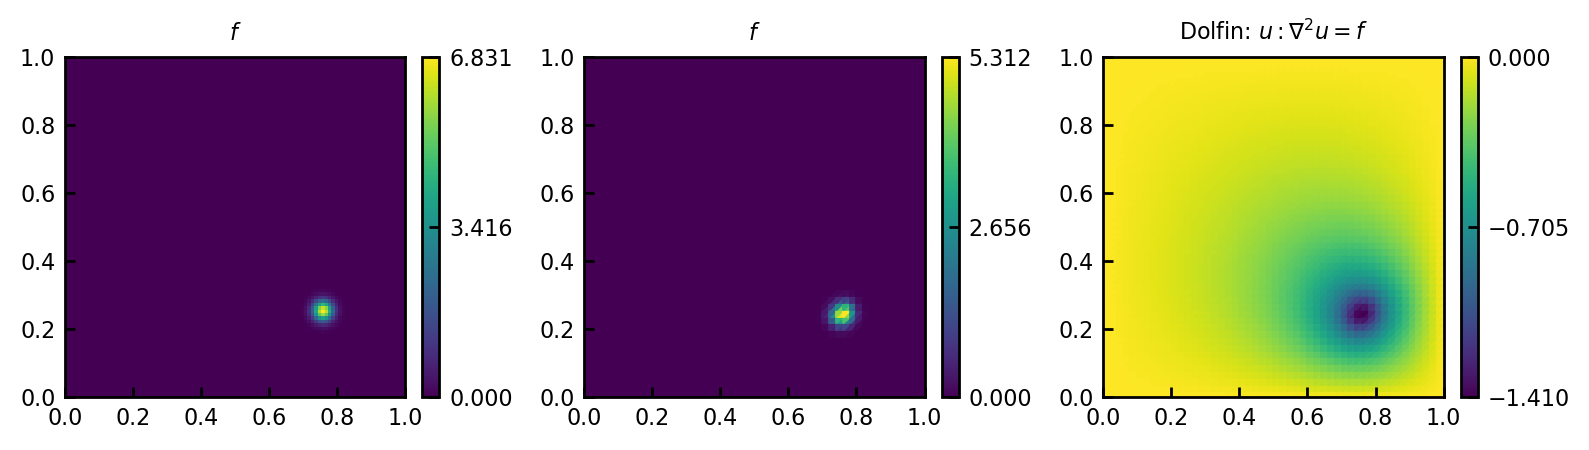

In [24]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import *

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

inputs[2] = 0.
inputs[2, 25, 75] = 1.

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    force = 1e3 * gaussian_filter(xyc[2:], sigma=2) * np.sin(xyc[0:1]) * np.sin(xyc[1:2])
    return force

mesh_size = 50
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

F = forcing_function(inputs)
force = multichannel_img_to_mesh(F, X, Y, build_problem.function_space, return_function=True)

dlf_sol = build_problem.forward(force)

# Plot and compare
fig, ax = plt.subplots(1, 3, figsize=(8,2.5))
ax = ax.flatten()

# Forcing function
plot_grid(ax[0], F[0], X, Y)
ax[0].set_title(r'$f$')

plot_mesh(ax[1], force.compute_vertex_values(), mesh)
ax[1].set_title(r'$f$')

# Dolfin solutions
plot_mesh(ax[2], dlf_sol.compute_vertex_values(), mesh)
ax[2].set_title(r'Dolfin: $u: \nabla^2 u = f$')

Jhat = build_problem.reduced_functional(dlf_sol.compute_vertex_values())
print(f'Reduced functional loss: {Jhat(force.vector()[:]):.3g}')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

In [9]:
import h5py
from tqdm import trange

dataset_size = 256
mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildPoissonProblem(mesh)

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

with h5py.File('poisson_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        inputs[2] = 0.
        for j in range(5):
            inputs[2, np.random.randint(25, 75), np.random.randint(25, 75)] += 1.

        force = forcing_function(inputs)
        force_mesh = multichannel_img_to_mesh(
            force, 
            X, 
            Y, 
            build_problem.function_space, 
            return_function=True)
        
        output = build_problem.forward(force_mesh).compute_vertex_values()

        h5f['inputs'][i] = inputs
        h5f['forces'][i] = force
        h5f['outputs'][i] = output

Opened file for writing


100%|██████████| 256/256 [00:06<00:00, 41.77it/s]


30


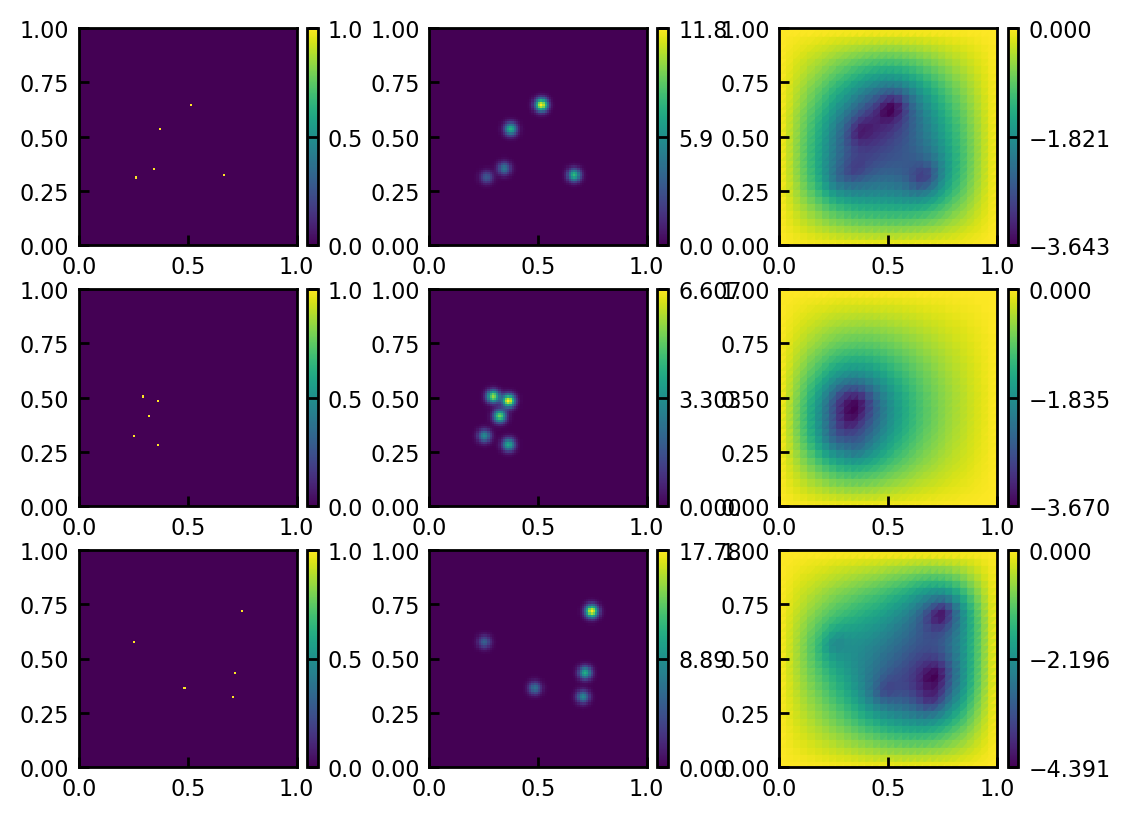

In [10]:
import h5py
fig, ax = plt.subplots(3, 3)

with h5py.File('poisson_dataset.hdf5', 'r') as h5f:
    print(h5f['mesh_size'][()])
    mesh = d_ad.UnitSquareMesh(nx=h5f['mesh_size'][()], ny=h5f['mesh_size'][()])

    for i in range(3):
        inputs = h5f['inputs'][i]
        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])
        plot_grid(ax[i,1], h5f['forces'][i,0], inputs[0], inputs[1])
        plot_mesh(ax[i,2], h5f['outputs'][i], mesh)


#file = dlf.File('square_mesh.xml')
#file << mesh

## 2D Incompressible Stokes equation

$$ \nabla^2 \mathbf{v} - \nabla p + \mathbf{f} = 0 $$

Subject to the incompressibility condition $\nabla \cdot \mathbf{v} = 0$

Reduced functional loss: 0


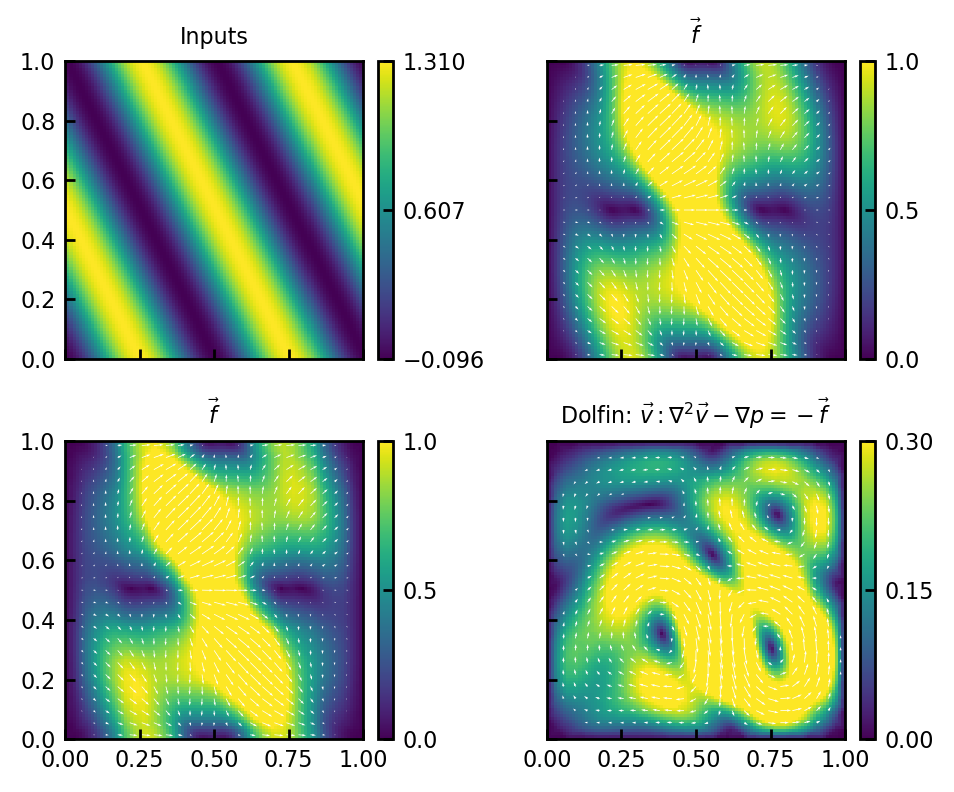

In [25]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildStokesProblem

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros(X.shape)
inputs = np.stack([X, Y, C], axis=0)

# Random fourier feature
kmax = 4
num_features = 2

rff = np.zeros([kmax, kmax])
rff[np.random.randint(0, kmax, size=num_features), 
    np.random.randint(0, kmax, size=num_features)] += np.random.random(size=num_features)
rff = np.fft.ifft2(rff, axes=(-2, -1), s=X.shape, norm='forward').real
rff = np.fft.ifftshift(rff, axes=(-2, -1))
inputs[2] = rff

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    force = np.zeros([2, *xyc.shape[1:]])
    force[0] =  np.sin(xyc[0] * np.pi) * gaussian_filter(xyc[2], sigma=2)
    force[1] = -np.sin(xyc[0] * np.pi) * np.sin(xyc[1] * 2 * np.pi) * gaussian_filter(1 + 0.2 * xyc[2], sigma=2)
    return force

F = forcing_function(inputs)

mesh_size = 30
mesh = d_ad.UnitSquareMesh(nx=mesh_size, ny=mesh_size)
build_problem = BuildStokesProblem(mesh)

force = multichannel_img_to_mesh(
    F, 
    X, 
    Y, 
    build_problem.function_space, 
    return_function=True)
dlf_sol = build_problem.forward(force)

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)
ax = ax.flatten()

# Input
plot_grid(ax[0], inputs[2], inputs[0], inputs[1])
ax[0].set_title('Inputs')

# Forcing function
plot_grid_vector(ax[1], F, X, Y, vmin=0, vmax=1) 
ax[1].set_title(r'$\vec{f}$')

# Plot functions on mesh
force_mesh = force.compute_vertex_values().reshape([2, -1])
plot_mesh_vector(ax[2], force_mesh, mesh, vmin=0, vmax=1)
ax[2].set_title(r'$\vec{f}$')

# Dolfin solutions
dlf_sol = dlf_sol.compute_vertex_values().reshape([2, -1])
plot_mesh_vector(ax[3], dlf_sol, mesh, vmin=0, vmax=0.3)
ax[3].set_title(r'Dolfin: $\vec{v}: \nabla^2 \vec{v} - \nabla p = -\vec{f}$')

Jhat = build_problem.reduced_functional(dlf_sol)
print(f'Reduced functional loss: {Jhat(force.vector()[:]):.3g}')

for a in ax:
    a.set_aspect('equal')

plt.tight_layout()

In [22]:
import h5py
from tqdm import trange

dataset_size = 256
mesh_size = 30
num_features = 2
kmax = 4
mesh = d_ad.Mesh('square_mesh.xml')
build_problem = BuildStokesProblem(mesh)

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

with h5py.File('stokes_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('num_fourier_features', data=num_features)
    h5f.create_dataset('kmax', data=kmax)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 2, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, 2, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        # Random fourier feature
        rff = np.zeros([kmax, kmax])
        rff[np.random.randint(0, kmax, size=num_features), 
            np.random.randint(0, kmax, size=num_features)] += np.random.random(size=num_features)
        rff = np.fft.ifft2(rff, axes=(-2, -1), s=X.shape, norm='forward').real
        rff = np.fft.ifftshift(rff, axes=(-2, -1))
        inputs[2] = rff

        force = forcing_function(inputs)
        force_mesh = multichannel_img_to_mesh(
            force, 
            X, 
            Y, 
            build_problem.function_space, 
            return_function=True)
        
        output = build_problem.forward(force_mesh).compute_vertex_values()
        output = output.reshape([2, -1])

        h5f['inputs'][i] = inputs
        h5f['forces'][i] = force
        h5f['outputs'][i] = output

Opened file for writing


100%|██████████| 256/256 [00:21<00:00, 11.74it/s]


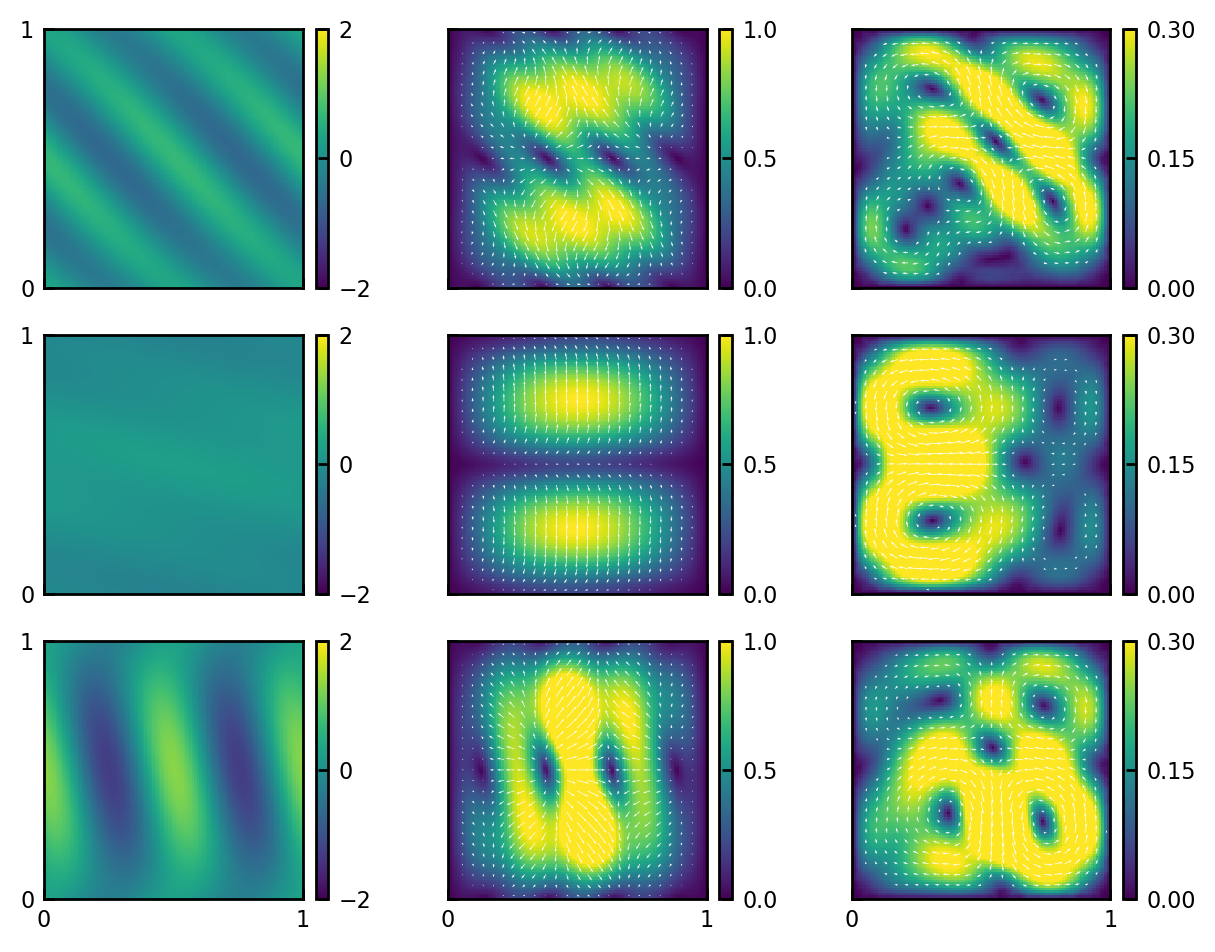

In [23]:
import h5py
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)

with h5py.File('stokes_dataset.hdf5', 'r') as h5f:
    mesh = d_ad.Mesh('square_mesh.xml')

    for i in range(3):
        inputs = h5f['inputs'][i]
        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1], vmin=-2, vmax=2)

        F = h5f['forces'][i]
        plot_grid_vector(ax[i,1], F, inputs[0], inputs[1], vmin=0, vmax=1)

        outputs = h5f['outputs'][i]
        plot_mesh_vector(ax[i,2], outputs, mesh, vmin=0, vmax=0.3)

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()

## 2D Elasticity + Adhesion equation

$$ U = \int dA\, \bigg[ \frac{h}{2} \big( \sigma_{ij}^{el} + \sigma^a \delta_{ij} \big)  u_{ij} + \frac{1}{2} Y(x) \mathbf{u}^2 \bigg] $$

The coefficient $\mathbf{Y}(x)$ is a tunable parameter field that determines adhesion stiffness. Here the elastic stress obeys the constitutive relation:

$$ \sigma_{ij}^{el} = \frac{E}{1 + \nu} \bigg( u_{ij} + \frac{\nu}{1 - 2\nu} u_{kk} \delta_{ij} \bigg) $$

Where $E$ is the Young's modulus and $\nu$ is the Poisson ratio of the material. Minimization of this energy leads to the partial differential equations

$$ h \partial_{ij} \sigma_{ij}^{el} = Y(x) u_i \quad \text{(bulk)} $$ 
$$ \sigma_{ij}^{el} n_j = -\sigma_a n_i \quad \text{(boundary)} $$

For this problem, we take a circular domain and consider localized regions of large $Y(x)$. Other coefficients are taken to be known and fixed constants

In [56]:
import pygmsh
import meshio

with pygmsh.geo.Geometry() as geom:
    print(geom)
    geom.add_circle((0.5, 0.5), radius=0.4, mesh_size=0.02)
    mesh = geom.generate_mesh(dim=2)

print(mesh)
mesh = meshio.Mesh(
    points=mesh.points[:, :2],
    cells=[("triangle", mesh.cells_dict["triangle"])]
)
meshio.write('circle_mesh.xml', mesh)

mesh = dlf.Mesh('circle_mesh.xml')

mesh

<pygmsh Geometry object>
<meshio mesh object>
  Number of points: 6015
  Number of cells:
    line: 252
    triangle: 11774
    vertex: 4


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Reduced functional loss: 6.68e-07


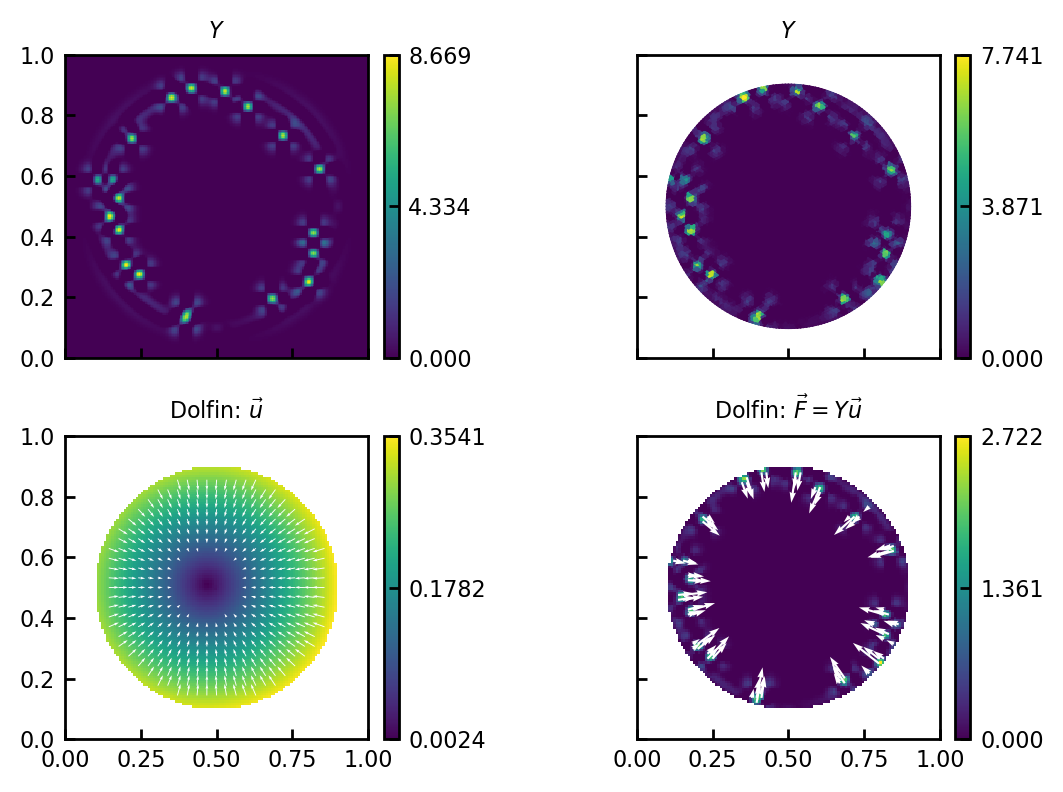

In [26]:
import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

# Turn off annoying log messages
import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
dlf.set_log_level(40)

from plot_utils import *
from mesh_utils import *
from dolfin_problems import BuildElasticityAdhesionProblem

X = np.linspace(0, 1, 200)
Y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(X, Y, indexing='xy')

r = np.sqrt((X - 0.5)**2 + (Y - 0.5)**2)
mask = r < 0.4

C = np.zeros(X.shape)
C[mask] = 0.1

allowed = np.argwhere(np.logical_and(mask, r > 0.3))
for j in range(20):
    idx = np.random.randint(0, len(allowed))
    point = allowed[idx]
    C[point[0], point[1]] += 10.

inputs = np.stack([X, Y, C], axis=0)

from scipy.ndimage import gaussian_filter
def forcing_function(xyc):
    """ Convolution of point sources with gaussian """
    inp = xyc[2:]
    Y = 5e8 * -gaussian_filter(inp, sigma=4, order=2)
    Y[Y < 0] = 0.
    return Y

mesh = d_ad.Mesh('circle_mesh.xml')
build_problem = BuildElasticityAdhesionProblem(mesh)

Y_grid = forcing_function(inputs)
Y_func = multichannel_img_to_mesh(Y_grid, X, Y, build_problem.function_space, return_function=True)

u_func = build_problem.forward(Y_func)

# Plot and compare
fig, ax = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
ax = ax.flatten()

# Forcing function
plot_grid(ax[0], Y_grid.squeeze(), X, Y, vmin=0)
ax[0].set_title(r'$Y$')

Y_mesh = Y_func.compute_vertex_values()
plot_mesh(ax[1], Y_mesh, mesh, vmin=0)
ax[1].set_title(r'$Y$')

u_mesh = u_func.compute_vertex_values().reshape([2, -1])

plot_mesh_vector(ax[2], u_mesh, mesh, N=100, downscale=4)
ax[2].set_title(r'Dolfin: $\vec{u}$')

plot_mesh_vector(ax[3], Y_mesh * u_mesh, mesh, downscale=2, threshold=0.5)
ax[3].set_title(r'Dolfin: $\vec{F} = Y \vec{u}$')

Jhat = build_problem.reduced_functional(Y_mesh * u_mesh)
print(f'Reduced functional loss: {Jhat(Y_func.vector()[:]):.3g}')

for a in ax:
    a.set(xlim=[0, 1], ylim=[0, 1])
    a.set_aspect('equal')

plt.tight_layout()

In [47]:
import h5py
from tqdm import trange

dataset_size = 256
mesh_size = 30
mesh = d_ad.Mesh('circle_mesh.xml')
build_problem = BuildElasticityAdhesionProblem(mesh)

X = np.linspace(0, 1, 200)
Y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(X, Y, indexing='xy')
C = np.zeros_like(X)
inputs = np.stack([X, Y, C], axis=0)

r = np.sqrt((X - 0.5)**2 + (Y - 0.5)**2)
mask = r < 0.4
allowed = np.argwhere(np.logical_and(mask, r > 0.3))


with h5py.File('elasticity_adhesion_dataset.hdf5', 'w') as h5f:
    print('Opened file for writing')
    h5f.create_dataset('mesh_size', data=mesh_size)
    h5f.create_dataset('dataset_size', data=dataset_size)

    h5f.create_dataset('inputs', shape=[dataset_size, *inputs.shape], dtype=np.float32)
    h5f.create_dataset('forces', shape=[dataset_size, 1, *inputs.shape[1:]], dtype=np.float32)
    h5f.create_dataset('outputs', shape=[dataset_size, 2, mesh.coordinates().shape[0]])

    for i in trange(dataset_size):
        inputs[2] = 0.

        inputs[2, mask] = 0.1

        for j in range(20):
            idx = np.random.randint(0, len(allowed))
            point = allowed[idx]
            inputs[2, point[0], point[1]] += 10.

        Y_grid = forcing_function(inputs)
        Y_func = multichannel_img_to_mesh(
            Y_grid, 
            X, 
            Y, 
            build_problem.function_space, 
            return_function=True)
        
        output = build_problem.forward(Y_func).compute_vertex_values()
        output = output.reshape([2, -1])
        output = output * Y_func.compute_vertex_values()
        h5f['inputs'][i] = inputs
        h5f['forces'][i] = Y_grid
        h5f['outputs'][i] = output

Opened file for writing


100%|██████████| 256/256 [01:27<00:00,  2.94it/s]


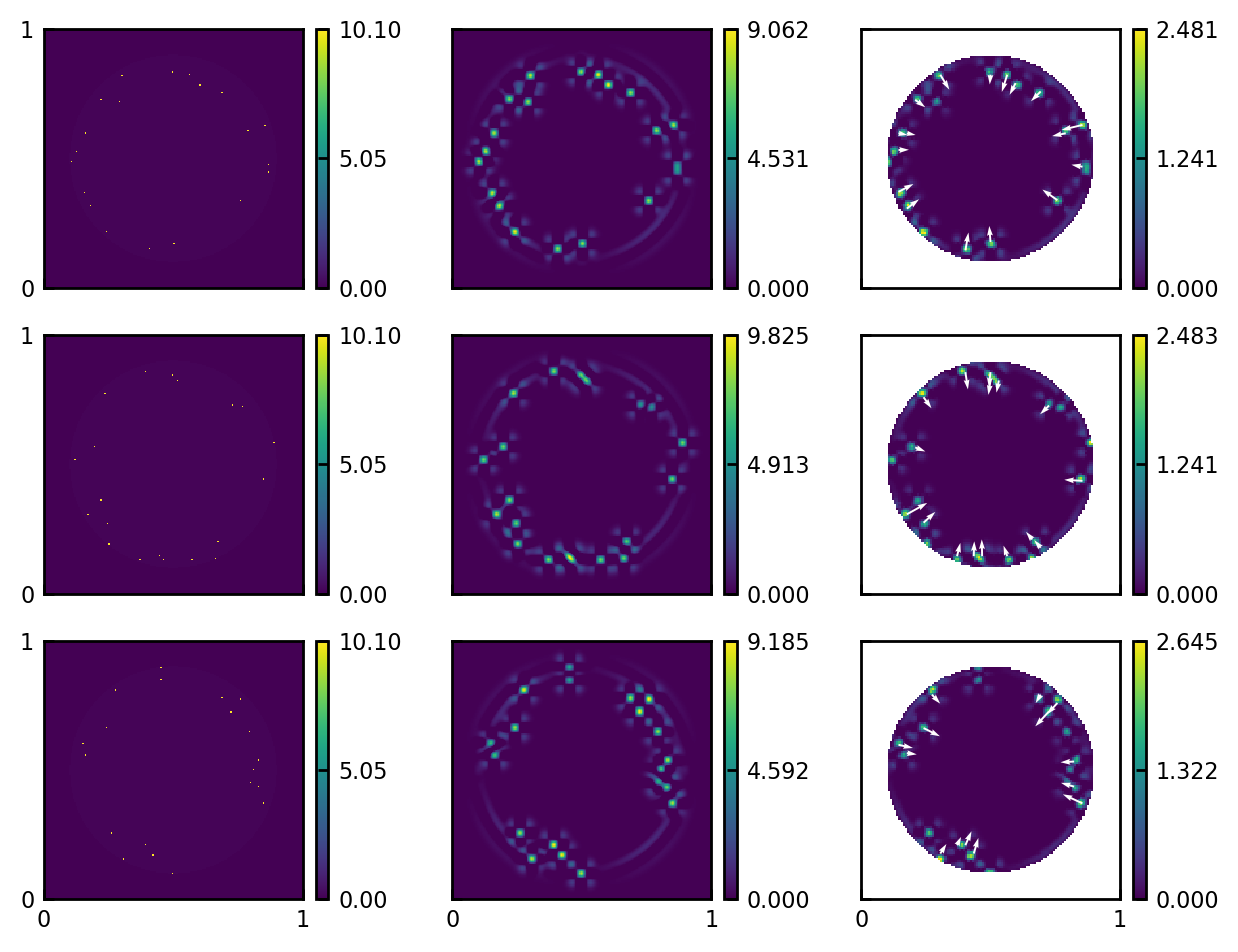

In [48]:
import h5py
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)

with h5py.File('elasticity_adhesion_dataset.hdf5', 'r') as h5f:
    mesh = d_ad.Mesh('circle_mesh.xml')

    for i in range(3):
        inputs = h5f['inputs'][i]
        plot_grid(ax[i,0], inputs[2], inputs[0], inputs[1])

        # Adhesion field function
        Y_grid = h5f['forces'][i]
        plot_grid(ax[i,1], Y_grid[0], inputs[0], inputs[1])

        # Force vectors
        outputs = h5f['outputs'][i]
        plot_mesh_vector(ax[i, 2], outputs, mesh, downscale=4, threshold=0.5)

for a in ax.flatten():
    a.set(xlim=[0, 1], ylim=[0, 1], xticks=[0, 1], yticks=[0, 1], aspect='equal')
    
plt.tight_layout()